# Neural Network Quantum State



In [1]:
import os
import json
import time
import sys

import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flax
import ray
# import flax.linen as nn
import netket as nk
import netket.nn as nn

from scipy.sparse.linalg import eigsh
from netket.operator.spin import sigmaz, sigmax 
from ray import tune
from tqdm.autonotebook import tqdm
from IPython.display import display

# Our source code
# Change the imported model to aklt_model etc.
from j1j2_model import OurModel, setup_problem, setup_model, ray_train_loop
#from aklt_model import OurModel, setup_problem, setup_model, ray_train_loop 

<ipython-input-1-eab5aa2688bb>:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Choose whether to run hyperopt when calling (use this only if converted to .py)
#HYPEROPT = bool(sys.argv[1])
#PLOTTING = bool(sys.argv[2])

In [3]:
os.environ["JAX_PLATFORM_NAME"] = "cpu" # or gpu
# os.environ["RAY_PICKLE_VERBOSE_DEBUG"] = "1" # RAY DEBUG
# os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"  # force gpu w/o right drivers

# Toggle hyperparameter optimization
skip_training = True
print(f'{nk.utils.mpi.available=}')

# Force detecting GPU in WSL
ray.shutdown()
ray.init(num_gpus=1)

nk.utils.mpi.available=False


RayContext(dashboard_url='', python_version='3.9.1', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-24_20-15-05_544032_23929/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-24_20-15-05_544032_23929/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-24_20-15-05_544032_23929', 'metrics_export_port': 62027, 'gcs_address': '127.0.0.1:60011', 'address': '127.0.0.1:60011', 'node_id': 'fd0058e7802564ad645f8c810cbd94645cd8913bb72196a4b9b4ee66'})

In [4]:
if not skip_training:
    from ray.tune.suggest.hyperopt import HyperOptSearch
    
    search_space = {
        'model': {
            'alpha': tune.randint(1, 3+1), # last value exclusive
        },
        # 'activation': tune.choice(['tanh', 'sigmoid']),
        'learning_rate': tune.uniform(0.0, 0.1),
        'n_epochs': 300, #tune.qrandint(100, 300, 50),
        'n_samples': 1008, #tune.qrandint(100, 1000, 100),
    }
    
    metric = "energy_error"
    mode = "min"

    hyperopt_search = HyperOptSearch(metric=metric, mode=mode)
    hyper_band_scheduler = tune.schedulers.ASHAScheduler(
        metric=metric,
        mode=mode,
        max_t=search_space['n_epochs'].max_value if isinstance(search_space['n_epochs'], tune.sample.Sampler) else search_space['n_epochs'],
        grace_period=20
    )

    analysis = tune.run(
        ray_train_loop,
        config=search_space,
        progress_reporter=tune.JupyterNotebookReporter(True, [metric]),
        scheduler=hyper_band_scheduler,
        resources_per_trial={"cpu": 6, 'gpu': 1/2},
        search_alg=hyperopt_search,
        num_samples=10,
        resume='AUTO',
        # metric=metric,
        # mode=mode,
    )

### Select best model parameters

In [5]:
# TODO

# Some system parameters
L = 14
J2 = 0.5

# Hyperparameters of the network
hyperparams = {
    'model': {
        'alpha': 1
    },
    'learning_rate': 0.07,
    'n_epochs': 100,
    'n_samples': 1008,
}

H, hi = setup_problem(J2=J2, L=L) # Remove the parameter for other models than j1j2. For j1j2 this chooses J2 when J1 = 1.0
eig_vals, _ = eigsh(H.to_sparse(), k=4, which="SA")
vstate, model, trainer = setup_model(H, hi, hyperparams) # this returns the hyperparam trainer instance too
display(f'{vstate.n_parameters=}')

# Used for keeping data accumulated during runtime
log = nk.logging.RuntimeLog()


'vstate.n_parameters=420'

In [6]:
# We need to specify the local operators as a matrix acting on a local Hilbert space 
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (sigmaz(hi, i)*sigmaz(hi, j))*((-1)**(i-j))/L


In [7]:
print(jnp.shape(structure_factor.to_dense()))

(3432, 3432)


In [8]:
# We need to specify the local operators as a matrix acting on a local Hilbert space 
neelm = []
sites = []
staggered_magn = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    staggered_magn += (sigmaz(hi, i) * (-1)**i)/L 

In [9]:
print(jnp.shape(staggered_magn.to_dense()))

(3432, 3432)


In [10]:
trainer.run(n_iter=hyperparams['n_epochs'], out=log, obs={
    'Structure Factor': structure_factor,
    'Staggered Magnetization': staggered_magn}
    )

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ", ffn_energy, error)

100%|██████████| 100/100 [00:06<00:00, 14.42it/s, Energy=-18.769-0.007j ± 0.038 [σ²=1.419, R̂=1.0060]]


Optimized energy and relative error:  -18.765+0.000j ± 0.029 [σ²=0.861, R̂=1.0144] 0.10644398216489138


In [11]:
# TODO load saved model
if skip_training:
    pass


## Results

History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=100)
History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=100)
History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=100)


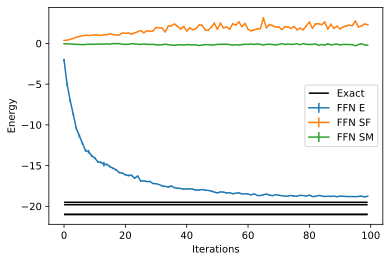

In [18]:
data = log.data

print(data["Energy"])
print(data["Structure Factor"])
print(data["Staggered Magnetization"])

#print(jnp.shape(data["Energy"].Mean))
#print(jnp.shape(data["Structure Factor"].Mean))
#print(jnp.shape(data["Staggered Magnetization"].Mean))

plt.errorbar(data["Energy"].iters, jnp.real(data["Energy"].Mean), yerr=data["Energy"].Sigma, label="FFN E")
plt.errorbar(data["Energy"].iters, jnp.real(data["Structure Factor"].Mean), yerr=data["Structure Factor"].Sigma, label="FFN SF")
plt.errorbar(data["Energy"].iters, jnp.real(data["Staggered Magnetization"].Mean), yerr=data["Staggered Magnetization"].Sigma, label="FFN SM")

#plt.hlines([E_gs_analytic], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.hlines([eig_vals], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

plt.savefig(fname="img/result.png", format="png", dpi=150)



In [13]:
# Test/debug/monitoring cell
print(eig_vals)

[-21.         -21.         -19.80296988 -19.50955187]


### Wavefunctions

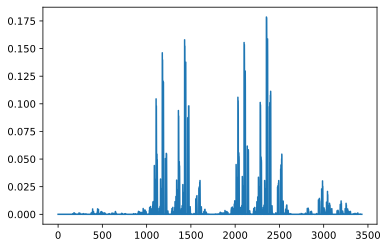

In [14]:
ket = vstate.to_array()

plt.plot(abs(ket))


In [15]:
# get quantum geometric tensor of state
# https://github.com/netket/netket/blob/2a7dded3db4705099d4de5450006b46b32ce34ca/netket/optimizer/qgt/qgt_onthefly_logic.py
qgt = vstate.quantum_geometric_tensor()
qgt

QGTOnTheFly(diag_shift=0.0)

In [16]:
QGT = qgt.to_dense()
jnp.imag(QGT)

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

# The AKLT Model

The AKLT model is an extension to the simple 1D Heisenberg spin model, proposed in 1987 by Affleck, I. et al.:

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.799

The model is essentially a 1D chain of spin-1/2 nuclei which form pairs. A constraint of having two spin-1/2 nuclei for each site is further imposed, which leads to the system being effectively a spin-1 system. This can be understood then to be a chain of these spin-1 "composite" nuclei. 

In the ground state of this Hamiltonian, every dimerized pair is referred to as a site and is given by a 

The AKLT Hamiltonian is given by a linear combination of the spin-1 projection operators in the respective Hilbert space $$\mathcal{H} \subset \mathbb{C}^3$$.